In [232]:
import numpy as np
from skimage import io
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import tarfile
import pandas as pd
import scipy
import matplotlib.pyplot as plt

In [233]:


tgz_path = '../../../Data/ZipFiles/lfw-funneled.tgz'

with tarfile.open(tgz_path, 'r:gz') as tar:
    tar.extractall(path='../A2-2')

C:\Users\johan\AppData\Local\Temp\ipykernel_19396\721106515.py:4: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path='../A2-2')


In [234]:
import os

main_path = '../A2-2/lfw_funneled'

person_image_count = {}

#Durchsuchen aller Verzeichnisse und Dateien
for person_directorys in os.listdir(main_path):
    person_directory_path = os.path.join(main_path, person_directorys)

    if os.path.isdir(person_directory_path):  #Wegen // Nur directorys wegen Datei pairs.txt
        image_count = 0

        for person_image_file in os.listdir(person_directory_path):
            image_count += 1
        person_image_count[person_directorys] = image_count

#Personen mit mindestens 70 Bildern
persons_with_min_70_images = {}
for person, count in person_image_count.items():
    if count >= 70:
        persons_with_min_70_images[person] = count

persons_with_min_70_images


{'Ariel_Sharon': 77,
 'Colin_Powell': 236,
 'Donald_Rumsfeld': 121,
 'George_W_Bush': 530,
 'Gerhard_Schroeder': 109,
 'Hugo_Chavez': 71,
 'Tony_Blair': 144}

In [235]:
def image_normalizing(image_path_array):
    normalized_images = []

    for image_path in image_path_array:
        #Bild laden + Graustufen
        image = io.imread(image_path, as_gray=True)
        # Crop to central region (eyes and mouth area)
        h, w = image.shape
        image = image[50:h - 50, 100:w - 100]
        image = resize(image, (32, 32), anti_aliasing=True)
        image = image.flatten()
        normalized_images.append(image)
    return np.array(normalized_images)

In [236]:

main_path = '../A2-2/lfw_funneled'

design_matrix = []
person_names = []
images = []
image_paths = []

#Bilder laden
for person, count in persons_with_min_70_images.items():
    person_image_path = os.path.join(main_path, person)

    person_images = []

    #Alle Bilder zu image_files hinzufügen und alle Pfade zu image_paths
    for file in os.listdir(person_image_path):
        person_directory_path = os.path.join(main_path, person)
        image_path = os.path.join(person_directory_path, file)
        image_paths.append(image_path)
        images.append(file)
        person_names.append(person)
        person_images.append(file)

#Bilder normalisieren
normalized_images = image_normalizing(image_paths)

print('Normalisierte Bilder: ', normalized_images)


Normalisierte Bilder:  [[0.76409874 0.76333559 0.7618745  ... 0.45180102 0.42390687 0.43632657]
 [0.97910903 0.98045155 0.97151955 ... 0.56179417 0.62995189 0.68868346]
 [0.59485341 0.5977032  0.5983243  ... 0.31304711 0.31444899 0.30489816]
 ...
 [0.23897985 0.21993892 0.2156895  ... 0.29762261 0.34223762 0.39931353]
 [0.62935623 0.65686395 0.67785614 ... 0.81601545 0.87416314 0.76666479]
 [0.19643648 0.20220521 0.21811043 ... 0.33939117 0.30691648 0.28428258]]


In [237]:
# PCA-Funktion
def pca(X, r):
    # Schritt 1: Zentrieren
    mean_X = np.mean(X, axis=0)
    centered_X = X - mean_X

    # Schritt 2: Normalisieren
    std_X = np.std(centered_X, axis=0)
    normalized_X = centered_X / std_X

    # Schritt 3/4: Singulärwertzerlegung
    U, D, VT = np.linalg.svd(normalized_X)

    # Schritt 5 + 6: Projizieren der Hauptvektoren auf Datenmatrix
    V = VT[:r, :].T
    UD = normalized_X.dot(V)

    # Schritt 7: Standardabweichung der Hauptkomponenten berechnen
    std_UD = np.std(UD, axis=0, ddof=1)

    # Alternativer Ansatz für Standardabweichung der Hauptkomponenten
    n = X.shape[0]
    std_UDv2 = D / pow((n - 1), 2)

    return U, D, VT, UD, std_UD, V, std_UDv2, mean_X

In [238]:
num_components = 7

U, D, VT, UD, std_UD, V, std_UDv2, mean_X = pca(normalized_images, num_components)


In [239]:
projected_data = pd.DataFrame(normalized_images @ V)
#projected_data = (projected_data - projected_data.mean()) / projected_data.std()

In [240]:
projected_data.corr()

,0,1,2,3,4,5,6
0,1.000000,-0.034584,0.008091,0.236391,0.018528,-0.012957,-0.036918
1,-0.034584,1.000000,-0.051706,0.274198,-0.137404,-0.041137,0.025137
2,0.008091,-0.051706,1.000000,-0.084759,0.022713,0.026686,0.058313
3,0.236391,0.274198,-0.084759,1.000000,-0.058558,-0.023091,-0.032362
4,0.018528,-0.137404,0.022713,-0.058558,1.000000,0.025027,-0.078282
5,-0.012957,-0.041137,0.026686,-0.023091,0.025027,1.000000,-0.070188
6,-0.036918,0.025137,0.058313,-0.032362,-0.078282,-0.070188,1.000000


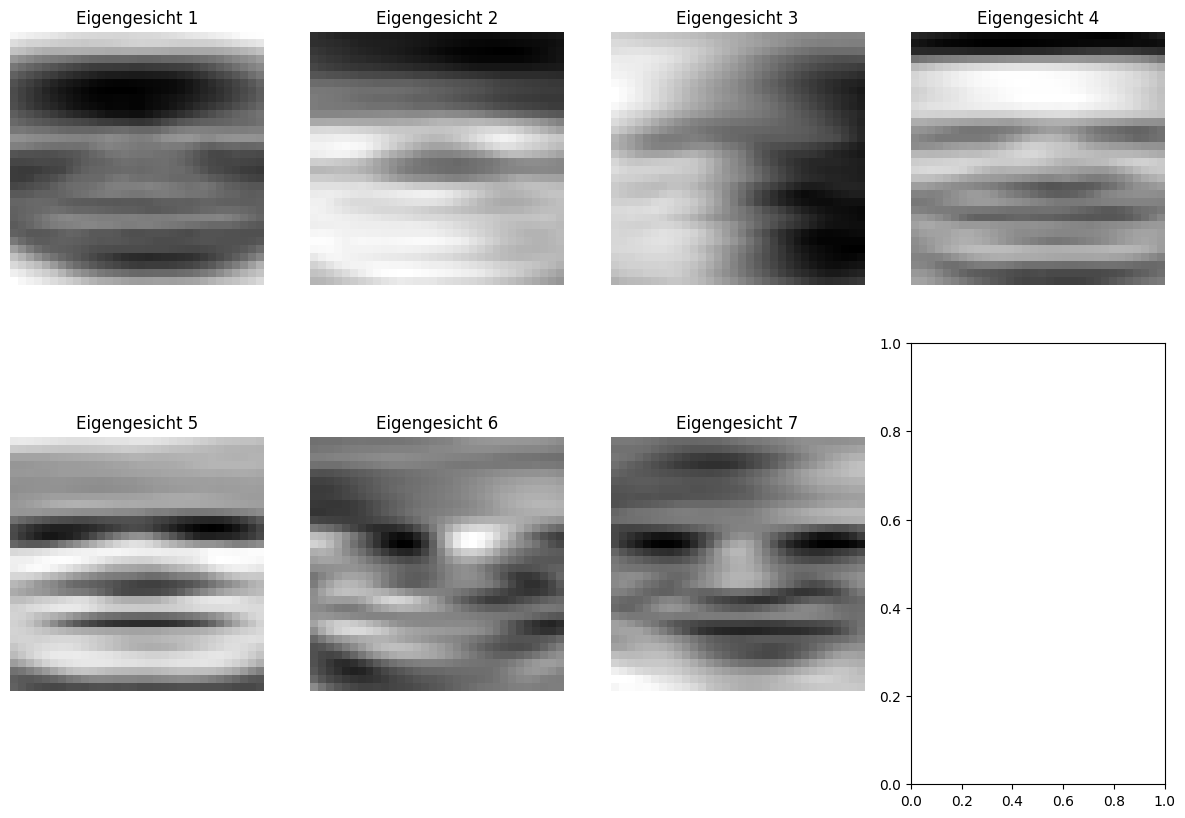

In [241]:
fig, axes = plt.subplots(2, 4, figsize=(12, 9))
axes = axes.ravel()
for i in range(len(V[1])):
    # Rücktransformation in Bildformat
    eig_face = V[:, i].reshape(32, 32)
    axes[i].imshow(eig_face, cmap='gray')
    axes[i].set_title(f'Eigengesicht {i + 1}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()


## 3. Naiver Bayesklassifikator zur Gesichtserkennung
Implementieren Sie den Gaussian-Naïve-Bayes-Klassifikator aus der Vorlesung. Testen Sie Ihre Implementierung am Datensatz ''Labeled Faces in the Wild'' aus Aufgabe 2, wiederum nur für Personen, für die mindestens 70 Bilder existieren. Teilen Sie Ihren Datensatz in 60 % Trainings- und 40% Testdaten (nach vorheriger Zufalls-Permutation der Reihenfolge) und skalieren Sie die Bilder wieder auf 1/8 der Originalgröße. Führen Sie anschließend eine Hauptkomponentenanalyse auf den Trainingsdaten durch und projizieren Sie sowohl Trainings- als auch Testbilder auf die ersten 7 Eigengesichter. Trainieren Sie Ihren GNB-Klassifikator auf dem Trainingsdatensatz als ''George-W.-Bush-Detektor'', d.h. alle zu dieser Person gehörigen Bilder werden mit 1 gelabelt, alle sonstigen mit –1. Werten Sie Ihren Klassifikator sowohl auf den Trainings- wie auf den unabhängigen Testdaten aus. Bestimmen Sie dafür jeweils die Detektionswahrscheinlichkeit, Richtig-Negativ-Rate, Fehlalarmrate und Falsch-Negativ-Rate.


#### Permutation & Preprocessing

In [242]:
df = pd.DataFrame(projected_data)
df["Names"] = person_names


def desicion_fkt(name, name_searched, labels=[1, -1]):
    return labels[0] if name == name_searched else labels[1]


df["Labels"] = df["Names"].transform(lambda name: desicion_fkt(name, 'George_W_Bush'))

df_bush = df.loc[df['Labels'] == 1]
df_not_bush = df.loc[df['Labels'] == -1]

A_priori_bush = len(df_bush) / (len(df_bush) + len(df_not_bush))
A_priori_not_bush = len(df_not_bush) / (len(df_bush) + len(df_not_bush))

xt_no_bush, xte_no_bush = train_test_split(df_not_bush, test_size=0.4, random_state=42)
xt_bush, xte_bush = train_test_split(df_bush, test_size=0.4, random_state=42)

xt = pd.concat([xt_bush, xt_no_bush])
xte = pd.concat([xte_no_bush, xte_bush])

yt_no_bush = xt_no_bush.pop("Labels")
yt_no_bush_name = xt_no_bush.pop("Names")

yt_bush = xt_bush.pop("Labels")
yt_bush_name = xt_bush.pop("Names")

#yte = xte.pop('Labels')
#yte_names = xte.pop('Names')

print(
    f"A-Priori-Bush: {A_priori_bush}, A-Priori-Not-Bush: {A_priori_not_bush}, SUM: {A_priori_bush + A_priori_not_bush}")

A-Priori-Bush: 0.4114906832298137, A-Priori-Not-Bush: 0.5885093167701864, SUM: 1.0


In [243]:
xt_bush

,0,1,2,3,4,5,6
575,-19.344120,-1.415254,4.120229,-1.275557,0.484732,-0.318927,1.558645
826,-13.531748,-2.216955,3.316246,-0.207453,0.740889,-0.709785,0.994716
501,-22.747065,-2.388673,-1.499291,-2.784472,0.624037,0.259378,0.966586
904,-18.268116,0.510119,2.922429,-0.794236,0.980536,0.385480,-0.544872
602,-18.007117,-1.655474,0.777385,-2.147378,0.888018,-0.338446,1.451803
...,...,...,...,...,...,...,...
505,-14.682047,0.466649,0.339883,-1.550703,1.407415,0.090889,0.877262
540,-17.512990,-1.678886,0.408744,-0.677415,2.074815,1.377641,0.159540
704,-16.915691,-4.332047,-1.174897,-2.364517,-0.421128,0.831757,1.284550
869,-16.390626,-1.420599,-0.749833,-1.249156,1.320532,-0.799960,0.509271


#### Gaussian Naive Bayes

##### Params Gauß

In [244]:
var_bush = xt_bush.var()
var_not_bush = xt_no_bush.var()

mean_bush = xt_bush.mean()
mean_not_bush = xt_no_bush.mean()

print(" | std_bush:\t\t| std_not_bush:\t\t| mean_bush:\t\t| mean_not_bush")
for i in range(len(var_bush)):
    print(
        f"{i}|{var_bush[i]}\t|{var_not_bush[i]}\t|{mean_bush[i]}\t|{mean_not_bush[i]}")

 | std_bush:		| std_not_bush:		| mean_bush:		| mean_not_bush
0|5.469988074100909	|5.182013860742762	|-17.01414266731485	|-16.867208246725443
1|1.907002259646993	|2.8641568677476914	|-1.545410575117109	|-1.787960695129282
2|2.2207715389651184	|1.3967750614561631	|0.5938308831730903	|0.5855161977230885
3|0.6126840115680285	|1.6268962319540026	|-1.7040262753745754	|-1.2054154521595148
4|0.59294633819256	|0.5807092126290824	|0.6433183962363612	|-0.10145599908428776
5|0.5216871100248806	|0.4409102200727749	|0.013446519048758989	|0.03110893763194608
6|0.5298782947772921	|0.5049740345750292	|0.7901420367705547	|0.6349478008024774


##### Klassification

In [251]:
def gnb(data, mean1, var1, a_priori1, mean2, var2, a_priori2):
    p_1 = []
    p_2 = []
    labels_estimated = []

    for index, row in data.iterrows():
        p_1_feature = 0
        p_2_feature = 0
        for i in range(len(mean1)):
            #print(scipy.stats.norm.pdf(row[i], mean1[i], var1[i]) * a_priori1)
            p_1_feature = p_1_feature + np.log(
                scipy.stats.norm.pdf(row[i], mean1[i], var1[i]))  #* a_priori1)
            p_2_feature = p_2_feature + np.log(
                scipy.stats.norm.pdf(row[i], mean2[i], var2[i]))  #* a_priori2)

        p_1_feature = p_1_feature + np.log(a_priori1)
        p_2_feature = p_2_feature + np.log(a_priori2)

        p_1.append(p_1_feature)
        p_2.append(p_2_feature)
        if p_1_feature > p_2_feature:
            labels_estimated.append(1)
        else:
            labels_estimated.append(-1)

    return [p_1, p_2, labels_estimated]

In [253]:
[p_bush_test, p_not_bush_test, labels_estimated_test] = gnb(xte, mean_bush, var_bush, A_priori_bush, mean_not_bush,
                                                            var_not_bush, A_priori_not_bush)

xte["P_bush"] = p_bush_test
xte["P_not_bush"] = p_not_bush_test
xte["Labels_estimated"] = labels_estimated_test

[p_bush_train, p_not_bush_train, labels_estimated_train] = gnb(xt, mean_bush, var_bush, A_priori_bush, mean_not_bush,
                                                               var_not_bush, A_priori_not_bush)

xt["P_bush"] = p_bush_train
xt["P_not_bush"] = p_not_bush_train
xt["Labels_estimated"] = labels_estimated_train

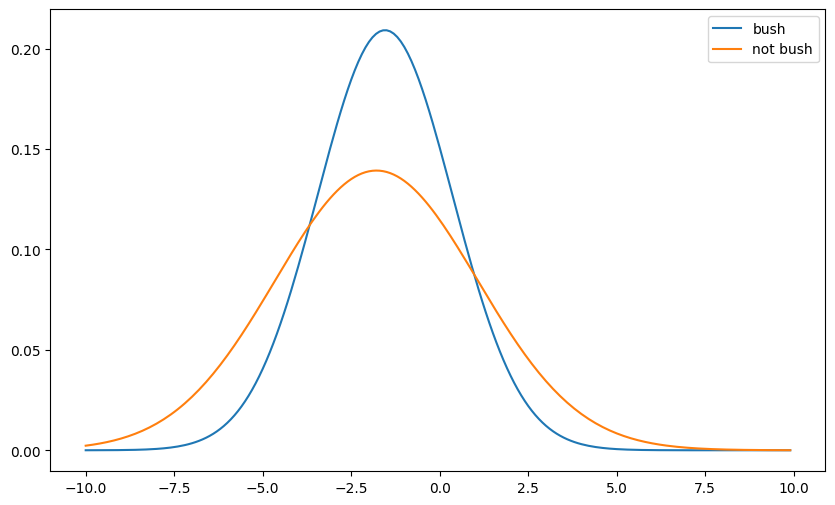

In [254]:
eigengesicht = 1
x = np.arange(-10, 10, 0.1)
norm_yte = scipy.stats.norm.pdf(x, mean_bush[eigengesicht], var_bush[eigengesicht])
norm_yte_hat = scipy.stats.norm.pdf(x, mean_not_bush[eigengesicht], var_not_bush[eigengesicht])

plt.figure(figsize=(10, 6))
plt.plot(x, norm_yte, label='bush')
plt.plot(x, norm_yte_hat, label='not bush')

plt.legend()
plt.show()

In [255]:
def metriken(xt):
    true_positive = ((xt["Labels"] == 1) & (xt["Labels_estimated"] == 1)).sum()  # TP
    true_negative = ((xt["Labels"] == -1) & (xt["Labels_estimated"] == -1)).sum()  # TN
    false_positive = ((xt["Labels"] == -1) & (xt["Labels_estimated"] == 1)).sum()  # FP
    false_negative = ((xt["Labels"] == 1) & (xt["Labels_estimated"] == -1)).sum()  # FN

    detektionswahrscheinlichkeit = true_positive / (true_positive + false_negative) if (
                                                                                               true_positive + false_negative) > 0 else 0
    richtig_negativ_rate = true_negative / (true_negative + false_positive) if (
                                                                                       true_negative + false_positive) > 0 else 0
    fehlalarmrate = false_positive / (false_positive + true_negative) if (false_positive + true_negative) > 0 else 0
    falsch_negativ_rate = false_negative / (true_positive + false_negative) if (
                                                                                       true_positive + false_negative) > 0 else 0

    print(f"Detektionswahrscheinlichkeit (True Positive Rate): {detektionswahrscheinlichkeit:.2%}")
    print(f"Richtig-Negativ-Rate (True Negative Rate): {richtig_negativ_rate:.2%}")
    print(f"Fehlalarmrate (False Positive Rate): {fehlalarmrate:.2%}")
    print(f"Falsch-Negativ-Rate (False Negative Rate): {falsch_negativ_rate:.2%}")


In [256]:
metriken(xt)

Detektionswahrscheinlichkeit (True Positive Rate): 71.38%
Richtig-Negativ-Rate (True Negative Rate): 82.16%
Fehlalarmrate (False Positive Rate): 17.84%
Falsch-Negativ-Rate (False Negative Rate): 28.62%


In [257]:
metriken(xte)

Detektionswahrscheinlichkeit (True Positive Rate): 73.11%
Richtig-Negativ-Rate (True Negative Rate): 77.96%
Fehlalarmrate (False Positive Rate): 22.04%
Falsch-Negativ-Rate (False Negative Rate): 26.89%
